The following notebook illustrates how to manipulate the data generated by

1. Dave Paul's scripts that extract the Intel DCT data from all of the NVMe devices across the Cori burst buffer, and
2. my atgtools/parse_dct_stats.py script that munges the data produced by Dave's scripts

It creates a set of DataFrames that aggregate NVMe device data on a per-node basis to simplify the process of determining how different metrics vary within nodes and between nodes.

In [92]:
import pandas
import json
import numpy as np

In [93]:
%matplotlib inline
%cd '/Users/glock/Google Drive/SSIO/Intel DCT'

/Users/glock/Google Drive/SSIO/Intel DCT


In [94]:
### Load the dataframe generated by atgtools/parse_dct_stats.py
df = pandas.DataFrame.from_csv('nvme_raw.csv')

In [95]:
### Add node names to the dataframe
serialno_to_nodename = json.load( open('nvme_name_map.json', 'r') )
df['nodename'] = [ serialno_to_nodename[x] for x in df.index ]

In [96]:
### Create a new dataframe of per-node data
df_precursor = {}
for i, row in df.iterrows():
    node = row['nodename']
    ssd_idx = row['Index']
    if node not in df_precursor:
        df_precursor[node] = {}
    df_precursor[node]["%s_TiB_%d" % ('DataUnitsRead', ssd_idx)] = row['DataUnitsRead']*1000.0*512/2**40
    df_precursor[node]["%s_TiB_%d" % ('DataUnitsWritten', ssd_idx)] = row['DataUnitsWritten']*1000.0*512/2**40
    df_precursor[node]["%s_%d" % ('WAF', ssd_idx)] = float(row['NAND_Bytes_Written_Raw'])/row['Host_Bytes_Written_Raw']
    
per_node_rw = pandas.DataFrame.from_dict( df_precursor, orient='index')

In [97]:
### Add per-node aggregate statistics -- initialize new rows
for key in [ 'DataUnitsRead_TiB', 'DataUnitsWritten_TiB', 'WAF' ]:
    for metric in [ 'Avg', 'StDev', 'CV' ]:
        per_node_rw["%s_%s" % (key, metric)] = np.nan

### Add per-node aggregate statistics -- calculate aggregate metrics
for _, row in per_node_rw.iterrows():
    for key in [ 'DataUnitsRead_TiB', 'DataUnitsWritten_TiB', 'WAF' ]:
        data_array = np.array([ row['%s_%d' % (key, j)] for j in range(4)])
        row[key+'_Avg'] = np.mean( data_array )
        row[key+'_StDev'] = np.std( data_array )
        row[key+'_CV'] = row[key+'_StDev'] / row[key+'_Avg']

In [98]:
### Sort the DataFrame
per_node_rw = per_node_rw[sorted(per_node_rw.keys())]

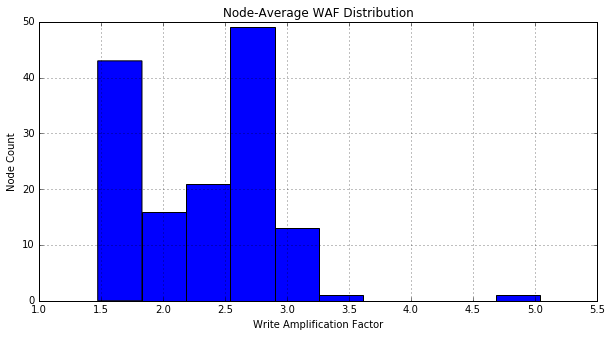

In [120]:
### Plot the WAF distribution directly from the DataFrame
axs = per_node_rw.hist(column='WAF_Avg', figsize=(10,5))
axs[0,0].set_xlabel("Write Amplification Factor")
axs[0,0].set_ylabel("Node Count")
axs[0,0].set_title("Node-Average WAF Distribution")